In [30]:
from utilities.proj1_helpers import load_csv_data
import numpy as np
from utilities.pca import compute_pca
from utilities.preprocessing import standard_scaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utilities.proj1_helpers import *

In [39]:
train_data = load_csv_data("data/train.csv")
y_train, x_train, ids_train = train_data[0], train_data[1], train_data[2]

indices = [i for i in range(30)]
#del indices[23]

y_train = y_train[indices]
x_train = x_train[:, indices]
ids_train = ids_train[indices]

y_train[np.where(y_train == -1)] = 0
N, D = x_train.shape
print(y_train.shape, x_train.shape, ids_train.shape)

(30,) (250000, 30) (30,)


In [40]:
df = pd.DataFrame(x_train)
df = df[df > 0]
axis = [i for i in range(len(df))]
if False:
    for i in df.columns.values:
        print(i)
        fig, ax = plt.subplots()
        df[i].hist(bins=100)
        #ax.set_yscale('log')
        plt.show()

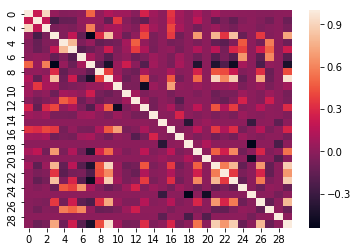

In [42]:
c = df.corr()
sns.heatmap(c)
plt.show()

In [7]:
df = np.log(df)
df.replace(np.nan, -999.0, inplace=True)
x_train = df.values

In [8]:
# Params to bruteforce
lambdas = np.logspace(-5, 1, 10)
degrees = np.arange(1, 8, 1)
k_folds = 4
seed = 1

In [21]:
from regression.linear_models import *
from utilities.cross_validation import cross_validation, build_k_indices, split_data
from regression.loss import compute_rmse_loss, compute_logistic_loss
from utilities.preprocessing import standard_scaler_outlier

In [22]:
x_scaled, means, sds = standard_scaler_outlier(x_train, -999)
x_scaled = np.c_[np.ones(x_scaled.shape[0]), x_scaled]

In [23]:
from utilities.pca import compute_pca
from utilities.stochastic import sigmoid, stochastic_gradient_descent
from regression.stochastic_models import *

In [25]:
x_pca, eig_pca = compute_pca(x_scaled, number_pc=x_scaled.shape[1])
x_tr_s, y_tr_s, x_te_s, y_te_s =split_data(x_scaled, y_train, 0.8)
x_tr_p, y_tr_p, x_te_p, y_te_p =split_data(x_pca, y_train, 0.8)

In [28]:
best_loss = 1e100
best_params = (-1, -1)
k_indices = build_k_indices(y_train, k_folds, seed)
degree = 1

for l in lambdas:
    ws = ridge_regression(y_tr_s, x_tr_s, l)
    loss_tr = compute_mse_loss(y_tr_s, x_tr_s, ws, l)
    loss_te = compute_mse_loss(y_te_s, x_te_s, ws, l)
    y_te_pred = predict_labels(ws, x_te_s)
    y_tr_pred = predict_labels(ws, x_tr_s)
    acc_tr = np.sum(y_tr_pred == y_tr_s) / len(y_tr_pred)
    acc_te = np.sum(y_te_pred == y_te_s) / len(y_te_pred)
    if loss_te < best_loss:
        best_loss = loss_te
        best_params = (l, degree)

    print("l={}: train {:.5f}, test {:.5f}; Acc: train {:.5f}, test {:.5f}".format(l, loss_tr, loss_te, acc_tr, acc_te))

l=1e-05: train 0.00121, test 5.06086; Acc: train 0.30435, test 0.00000
l=4.641588833612782e-05: train 0.00185, test 1.95767; Acc: train 0.30435, test 0.16667
l=0.00021544346900318823: train 0.00354, test 1.48490; Acc: train 0.30435, test 0.16667
l=0.001: train 0.00878, test 0.83065; Acc: train 0.30435, test 0.16667
l=0.004641588833612777: train 0.02147, test 0.51475; Acc: train 0.30435, test 0.16667
l=0.021544346900318822: train 0.04254, test 0.33646; Acc: train 0.30435, test 0.16667
l=0.1: train 0.06967, test 0.23931; Acc: train 0.30435, test 0.00000
l=0.46415888336127725: train 0.10248, test 0.21305; Acc: train 0.30435, test 0.16667
l=2.154434690031882: train 0.13167, test 0.19528; Acc: train 0.30435, test 0.16667
l=10.0: train 0.14640, test 0.17653; Acc: train 0.30435, test 0.00000


In [29]:
initial_w = np.ones(x_scaled.shape[1])

In [ ]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # polynomial basis function: TODO
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    # ***************************************************
    poly = np.array([x**j for j in range(degree+1)]).T
    return poly

def least_squares(y, tx):
    """calculate the least squares solution."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least squares: TODO
    # returns mse, and optimal weights
    # ***************************************************
    gram = (tx.T).dot(tx)
    N = len(y)
    try:
        w_star = np.linalg.inv(gram).dot(tx.T).dot(y)
    except np.linalg.LinAlgError:
        U, S, V = np.linalg.svd(tx)
        w_star = V.dot(np.linalg.pinv(S)).dot(U.T).dot(y)
    e = y-tx.dot(w_star)
    MSE = (e.T).dot(e)/(2*N)
    return MSE, w_star

def polynomial_regression(x, y):
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = range(10)
    best_params = (0, 0)
    w = 0
    loss = np.infty
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # form the data to do polynomial regression.: TODO
        # ***************************************************
        poly = build_poly(x, degree)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # least square and calculate RMSE: TODO
        # ***************************************************
        mse, weights = least_squares(y, poly)
        rmse = np.sqrt(2*mse)
        if rmse < loss:
            best_params = (degree, rmse)
            w = weights
            loss = rmse

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
    return best_params, w